# MODIS Water Random Forest

Version: 0.2.1

Date modified: 03.23.2022

Modified by: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
from pprint import pprint
import sys
import time

from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

#sys.path.append('../')
#import notebook_util as nu

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
FIGURE_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

training_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0'

qaMaskPath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'

GPU = True
TILE = 'Golden'
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']
# Columns that the user wants to drop for training purposes. 
colsToDrop = [] # ['sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1','ndwi1','ndwi2']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [3]:
colsToDrop

[]

In [4]:
colsToDropTraining

['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']

In [5]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF or pandas Dataframe
- Drop unnecessary columns
- Clean data
- Split into Xs and Ys
- Train-test split

In [6]:
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
data_paths = [fv for fv in glob.glob(glob_string)]
data_path = data_paths[0]
pprint(data_paths)

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip',
 '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_2.parquet.gzip']


In [7]:
%%time

X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDropTraining,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             splitXY=True,
                                             imbalance=False,
                                             trainTestSplit=True,
                                             multi=False)

kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

CPU times: user 1.04 s, sys: 200 ms, total: 1.24 s
Wall time: 1.12 s


5

In [8]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [9]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,805600.0,1410.757861,2215.132663,-100.0,147.0,723.0,1421.00,16000.0
sur_refl_b02_1,805600.0,2008.355350,2041.493127,-100.0,136.0,1978.0,2634.00,16000.0
sur_refl_b03_1,805600.0,1138.823040,2235.249953,-100.0,204.0,367.0,696.00,13347.0
sur_refl_b04_1,805600.0,1339.372195,2212.188704,-100.0,283.0,655.0,1063.00,16000.0
sur_refl_b05_1,805600.0,1945.522893,1828.318555,-28672.0,101.0,2311.0,3125.00,14954.0
sur_refl_b06_1,805600.0,1576.389292,1354.981528,-100.0,88.0,1529.0,2652.00,11197.0
sur_refl_b07_1,805600.0,441.324304,4335.876420,-28672.0,46.0,722.0,1748.00,7346.0
ndvi,805600.0,-304.684835,6827.822662,-32727.0,-3440.0,1258.5,4197.00,32679.0
ndwi1,805600.0,-1580.882910,6126.514866,-32758.0,-3192.0,-1057.0,1893.00,32762.0
ndwi2,805600.0,298.258118,7413.713872,-32745.0,-1506.0,1058.0,5346.25,32762.0


In [10]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [11]:
output_interesting_idx(X_train, 'ndvi', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
741393,5,-18,244,143,22,144,83,17692,-12857,-15538
205340,24,-14,85,114,37,51,0,27536,-17567,10000
750412,42,-24,260,149,98,58,-1,28870,-24117,9200
265386,6,-4,42,80,29,38,1,15536,-12352,16666
661513,20,-12,205,115,-45,43,-28672,25536,-17741,-9991
...,...,...,...,...,...,...,...,...,...,...
474833,21,-13,332,287,93,93,41,23036,-13250,-19285
813803,1,-30,196,98,0,38,31,10689,-19464,-20176
990038,8,-17,174,121,-39,61,15,27777,-17727,28928
318213,15,-10,151,88,24,41,18,15536,-16451,30536


# Model definition and training

In [12]:
hyperparameters = {'n_estimators': 400, 
                   'criterion':'gini', 
                   'max_depth':None, 
                   'min_samples_split':2, 
                   'min_samples_leaf':1, 
                   'min_weight_fraction_leaf':0.0, 
                   'max_features':'auto', 
                   'max_leaf_nodes':None, 
                   'min_impurity_decrease':0.0, 
                   'bootstrap':True, 
                   'oob_score':False, 
                   'n_jobs':-1, 
                   'random_state':42, 
                   'verbose':0, 
                   'warm_start':True, 
                   'class_weight':None, 
                   'ccp_alpha':0.0, 
                   'max_samples':None
                  }

In [13]:
classifier = skRF(**hyperparameters)

In [14]:
%%time
bestModel = None
bestModelScore = 0
scores = []
for trainIdx, testIdx in kf.split(X_train):
    print("Train {}, Test {}".format(trainIdx, testIdx))
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print('Fitting model')
    st = time.time()
    classifier.fit(X_train_valid, y_train_valid)
    et = time.time()
    print('Time to fit model: {}s'.format(et-st))
    print('Getting score')
    score = classifier.score(X_test_valid, y_test_valid)
    if score>=bestModelScore:
        bestModelScore = score
        print('Training accuracy score: {}'.format(score))
        bestModel = classifier
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test_valid)
    print(classification_report(y_test_valid, test_predictions))
    print('Score: {}'.format(score))
    scores.append(score)
    del test_predictions, score

Train [161120 161121 161122 ... 805597 805598 805599], Test [     0      1      2 ... 161117 161118 161119]
Fitting model
Time to fit model: 30.154304027557373s
Getting score
Training accuracy score: 0.9830126613704071
Predicting for test set
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     91339
           1       0.98      0.98      0.98     69781

    accuracy                           0.98    161120
   macro avg       0.98      0.98      0.98    161120
weighted avg       0.98      0.98      0.98    161120

Score: 0.9830126613704071
Train [     0      1      2 ... 805597 805598 805599], Test [161120 161121 161122 ... 322237 322238 322239]
Fitting model
Time to fit model: 0.04452037811279297s
Getting score
Training accuracy score: 0.999472442899702
Predicting for test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     91786
           1       1.00      1.00      1.00     6933

In [15]:
scoreAvg = np.asarray(scores).mean()
print('Average accuracy score: {}'.format(scoreAvg))
print('Best accuracy score: {}'.format(bestModelScore))

Average accuracy score: 0.9962077954319761
Best accuracy score: 0.999590367428004


## Regular fitting

In [16]:
classifier = skRF(**hyperparameters)

In [17]:
%%time

classifier.fit(X_train, y_train)

CPU times: user 25min 27s, sys: 4.44 s, total: 25min 32s
Wall time: 41 s


RandomForestClassifier(max_features='auto', n_estimators=400, n_jobs=-1,
                       random_state=42, warm_start=True)

## Model testing and training/testing data validation

### Get model metrics

In [18]:
classifier = bestModel

In [19]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.983

In [20]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [21]:
predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr[1])
predictionProbabilityArray = np.asarray(predictionProbabilityList)

### Show the distribution of the probability of the predicted values.

These are the probability that each test data point is water p=1 vs land p=0. Usually a relatively flatter distribution on one of the sides shows us that the model is not as confident on predicting that side.

Text(0.5, 1.0, 'Distribution of the probability of predicted values')

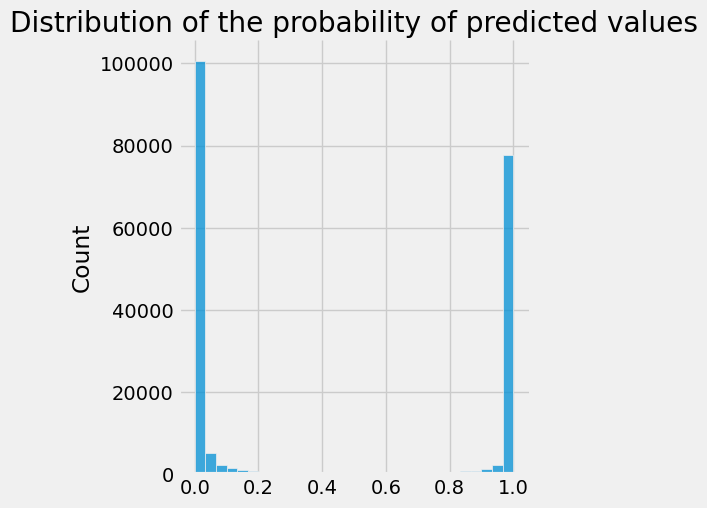

In [22]:
sns.displot(predictionProbabilityArray, bins=30)
plt.title('Distribution of the probability of predicted values')

In [23]:
test_predictions = test_predictions.astype(np.int32)
y_test_int = y_test.astype(np.int32)

In [24]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    114211
           1       0.98      0.98      0.98     87189

    accuracy                           0.98    201400
   macro avg       0.98      0.98      0.98    201400
weighted avg       0.98      0.98      0.98    201400

Test Recall
-------------------------------------------------------
0.9878908336324872
Confusion Matrix
-------------------------------------------------------
[[112828   1383]
 [  1980  85209]]


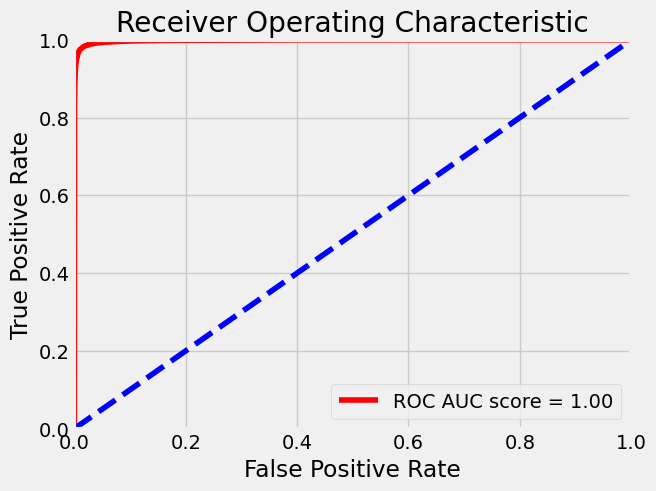

In [25]:
clf = classifier

probs = clf.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Permutaion importance

In [26]:
%%time
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

CPU times: user 19min 49s, sys: 6.86 s, total: 19min 56s
Wall time: 42 s


Text(0.5, 0, 'Permutation Importance')

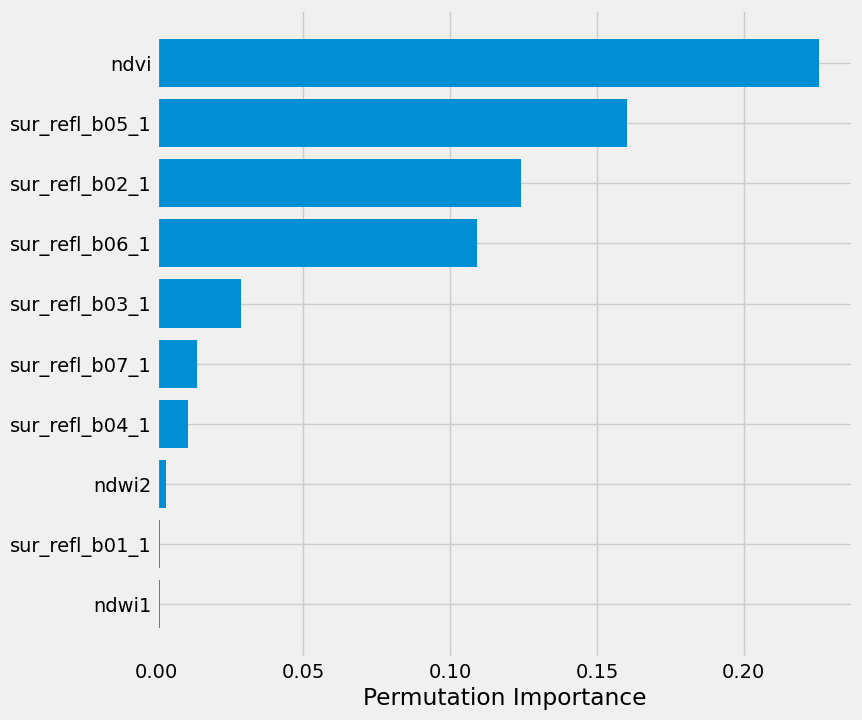

In [27]:
png_save_path = 'mw_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    hyperparameters['n_estimators'],
    MODEL,
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
# plt.savefig(png_save_path)

Garbage collection

In [28]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## Save the model for future use

In [29]:
model_save_path = 'mw_{}_{}_{}_{}_{}_2.0.0_tuned_{}.sav'.format(TILE,
                                                              score,
                                                              hyperparameters['n_estimators'],
                                                              MODEL,
                                                              'cpu',
                                                              datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.983_400_rf_cpu_2.0.0_tuned_2023_02_16_11_48.sav
RandomForestClassifier(max_features='auto', n_estimators=400, n_jobs=-1,
                       random_state=42, warm_start=True)


['/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.983_400_rf_cpu_2.0.0_tuned_2023_02_16_11_48.sav']

# Testing: raster testing

In [30]:
import sys
sys.path.append('../../..')
from modis_water_training.model.TabularModisDataGenerator import TabularModisDataGenerator

In [31]:
TILE = 'h11v10'
DAY = 201
YEAR = 2006
PATH = os.path.join(test_data_basepath, '{}/'.format(TILE))

In [32]:
tabularGen = TabularModisDataGenerator(tile=TILE, year=YEAR, julianDays=[DAY])
sensorDir = f'/css/modis/Collection6.1/L2G/MOD09GA/{YEAR}'
modisFilesDict = tabularGen._readFiles(julianDay=DAY, sensorDir=sensorDir)
modisFilesList = list(modisFilesDict.values())
qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)

/css/modis/Collection6.1/L2G/MOD09GA/2006/*GA.A2006201.h11v10*.hdf
/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf
Julian day: 201
Files: {'SensorZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SensorZenith_1', 'SolarZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SolarZenith_1', 'state_1km_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:state_1km_1', 'sur_refl_b03_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1', 'sur_refl_b04_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1', 'sur_refl_b05_1':

In [33]:
vars_list_gq = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list

['HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b01_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b02_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b05_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b06_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_r

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [34]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [35]:
%%time
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 282 2985  173 ... 8273 2822 6797]
 [ 289 3045  173 ... 8266 2913 6851]
 [ 275 3198  180 ... 8416 3050 6898]
 ...
 [ 317 1559  144 ... 6620  562 4395]
 [ 252 1447  126 ... 7033  770 4863]
 [ 252 1447  126 ... 7033  770 4863]]
460.8 MB size
CPU times: user 6.11 s, sys: 729 ms, total: 6.84 s
Wall time: 10.4 s


In [36]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [37]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)

Making predictions from raster
CPU times: user 38min 15s, sys: 3min 29s, total: 41min 44s
Wall time: 1min 36s


## Inputreshapet raster: description and histogram

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,23040000.0,1140.560665,1527.279099,-28672.0,227.0,463.0,1397.0,11069.0
sur_refl_b02_1,23040000.0,2658.499274,1132.979425,-28672.0,2082.0,2533.0,2899.0,10802.0
sur_refl_b03_1,23040000.0,829.334512,1460.147104,-28672.0,152.0,242.0,685.0,9552.0
sur_refl_b04_1,23040000.0,1086.797176,1447.336811,-28672.0,356.0,496.0,1055.0,10207.0
sur_refl_b05_1,23040000.0,2919.611193,1008.000270,-28672.0,2444.0,2757.0,3154.0,8725.0
sur_refl_b06_1,23040000.0,2214.756003,1198.891539,-28672.0,1332.0,1835.0,2798.0,7891.0
sur_refl_b07_1,23040000.0,1316.849571,1626.572310,-28672.0,431.0,873.0,2086.0,8951.0
ndvi,23040000.0,5099.909421,3622.130717,-32758.0,1772.0,6266.0,8435.0,32762.0
ndwi1,23040000.0,1035.434987,2495.314006,-32758.0,-812.0,825.0,3330.0,32762.0
ndwi2,23040000.0,3787.883306,3553.893702,-32758.0,542.0,4209.0,7222.0,32762.0


#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [39]:
shp = (4800, 4800)
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [40]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/*h11v10*.tif
/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/MOD44W_h11v10_2006_v5.tif


### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [41]:
maskedResult = np.where(qa_mask == 0, reshp, 255)
waterMasked = np.where(qa_mask == 0, waterMaskMatrix, 255)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

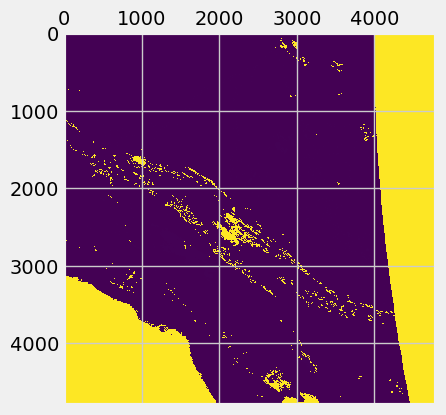

In [54]:
plt.matshow(waterMasked)

# Generating stats for predicted and truth

## Predicted Raster

In [42]:
import math

In [43]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))
mcc_denom_nosqrt = (truePositives+falsePositives)*(truePositives+falseNegatives)*(trueNegatives+falsePositives)*(trueNegatives+falseNegatives)
mcc_numerator = (truePositives*trueNegatives) - (falsePositives*falseNegatives)
mcc = mcc_numerator/math.sqrt(mcc_denom_nosqrt)

In [44]:
countNoData = np.count_nonzero(maskedResult == 255)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 Nodata occurences: 5671456
 Land occurance: 16826277
 Water occurances: 542267


In [45]:
countNoDataT = np.count_nonzero(waterMasked == 255)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Truth Vals
 Nodata occurences: 5671456
 Land occurance: 17043705
 Water occurances: 324839


### Model metrics on raster data

In [46]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))
print('MCC: {}'.format(mcc))

Metrics of Accuracy for Raster Test Data
True Positives:  300733
True Negatives:  16802171
False Positives: 241534
False Negatives: 24106
Total "good" data: 17368544
Accuracy*: 0.9847056840227943
Precision: 0.5545847340885578
Recall: 0.9257909302762292
f1: 0.6936476047911098
MCC: 0.7101156418636234


## Output predicted raster to GeoTiff

In [47]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_rf.tif
/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/waterMask_2006_qa_201.tif
/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_probabilities_rf.tif
Transform
(-7783653.637667, 231.65635826395845, 0.0, -1111950.519667, 0.0, -231.65635826374995)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800


In [48]:
import folium
from folium import plugins
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 

In [49]:
# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

In [53]:
outPath

'/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_rf.tif'

In [55]:
mask_3857 = reproject_to_3857(outPath)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask_path)

mask_d = get_bounds(mask_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292471.14|
| 0.00,-207.27,-1118891.21|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568


In [56]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)


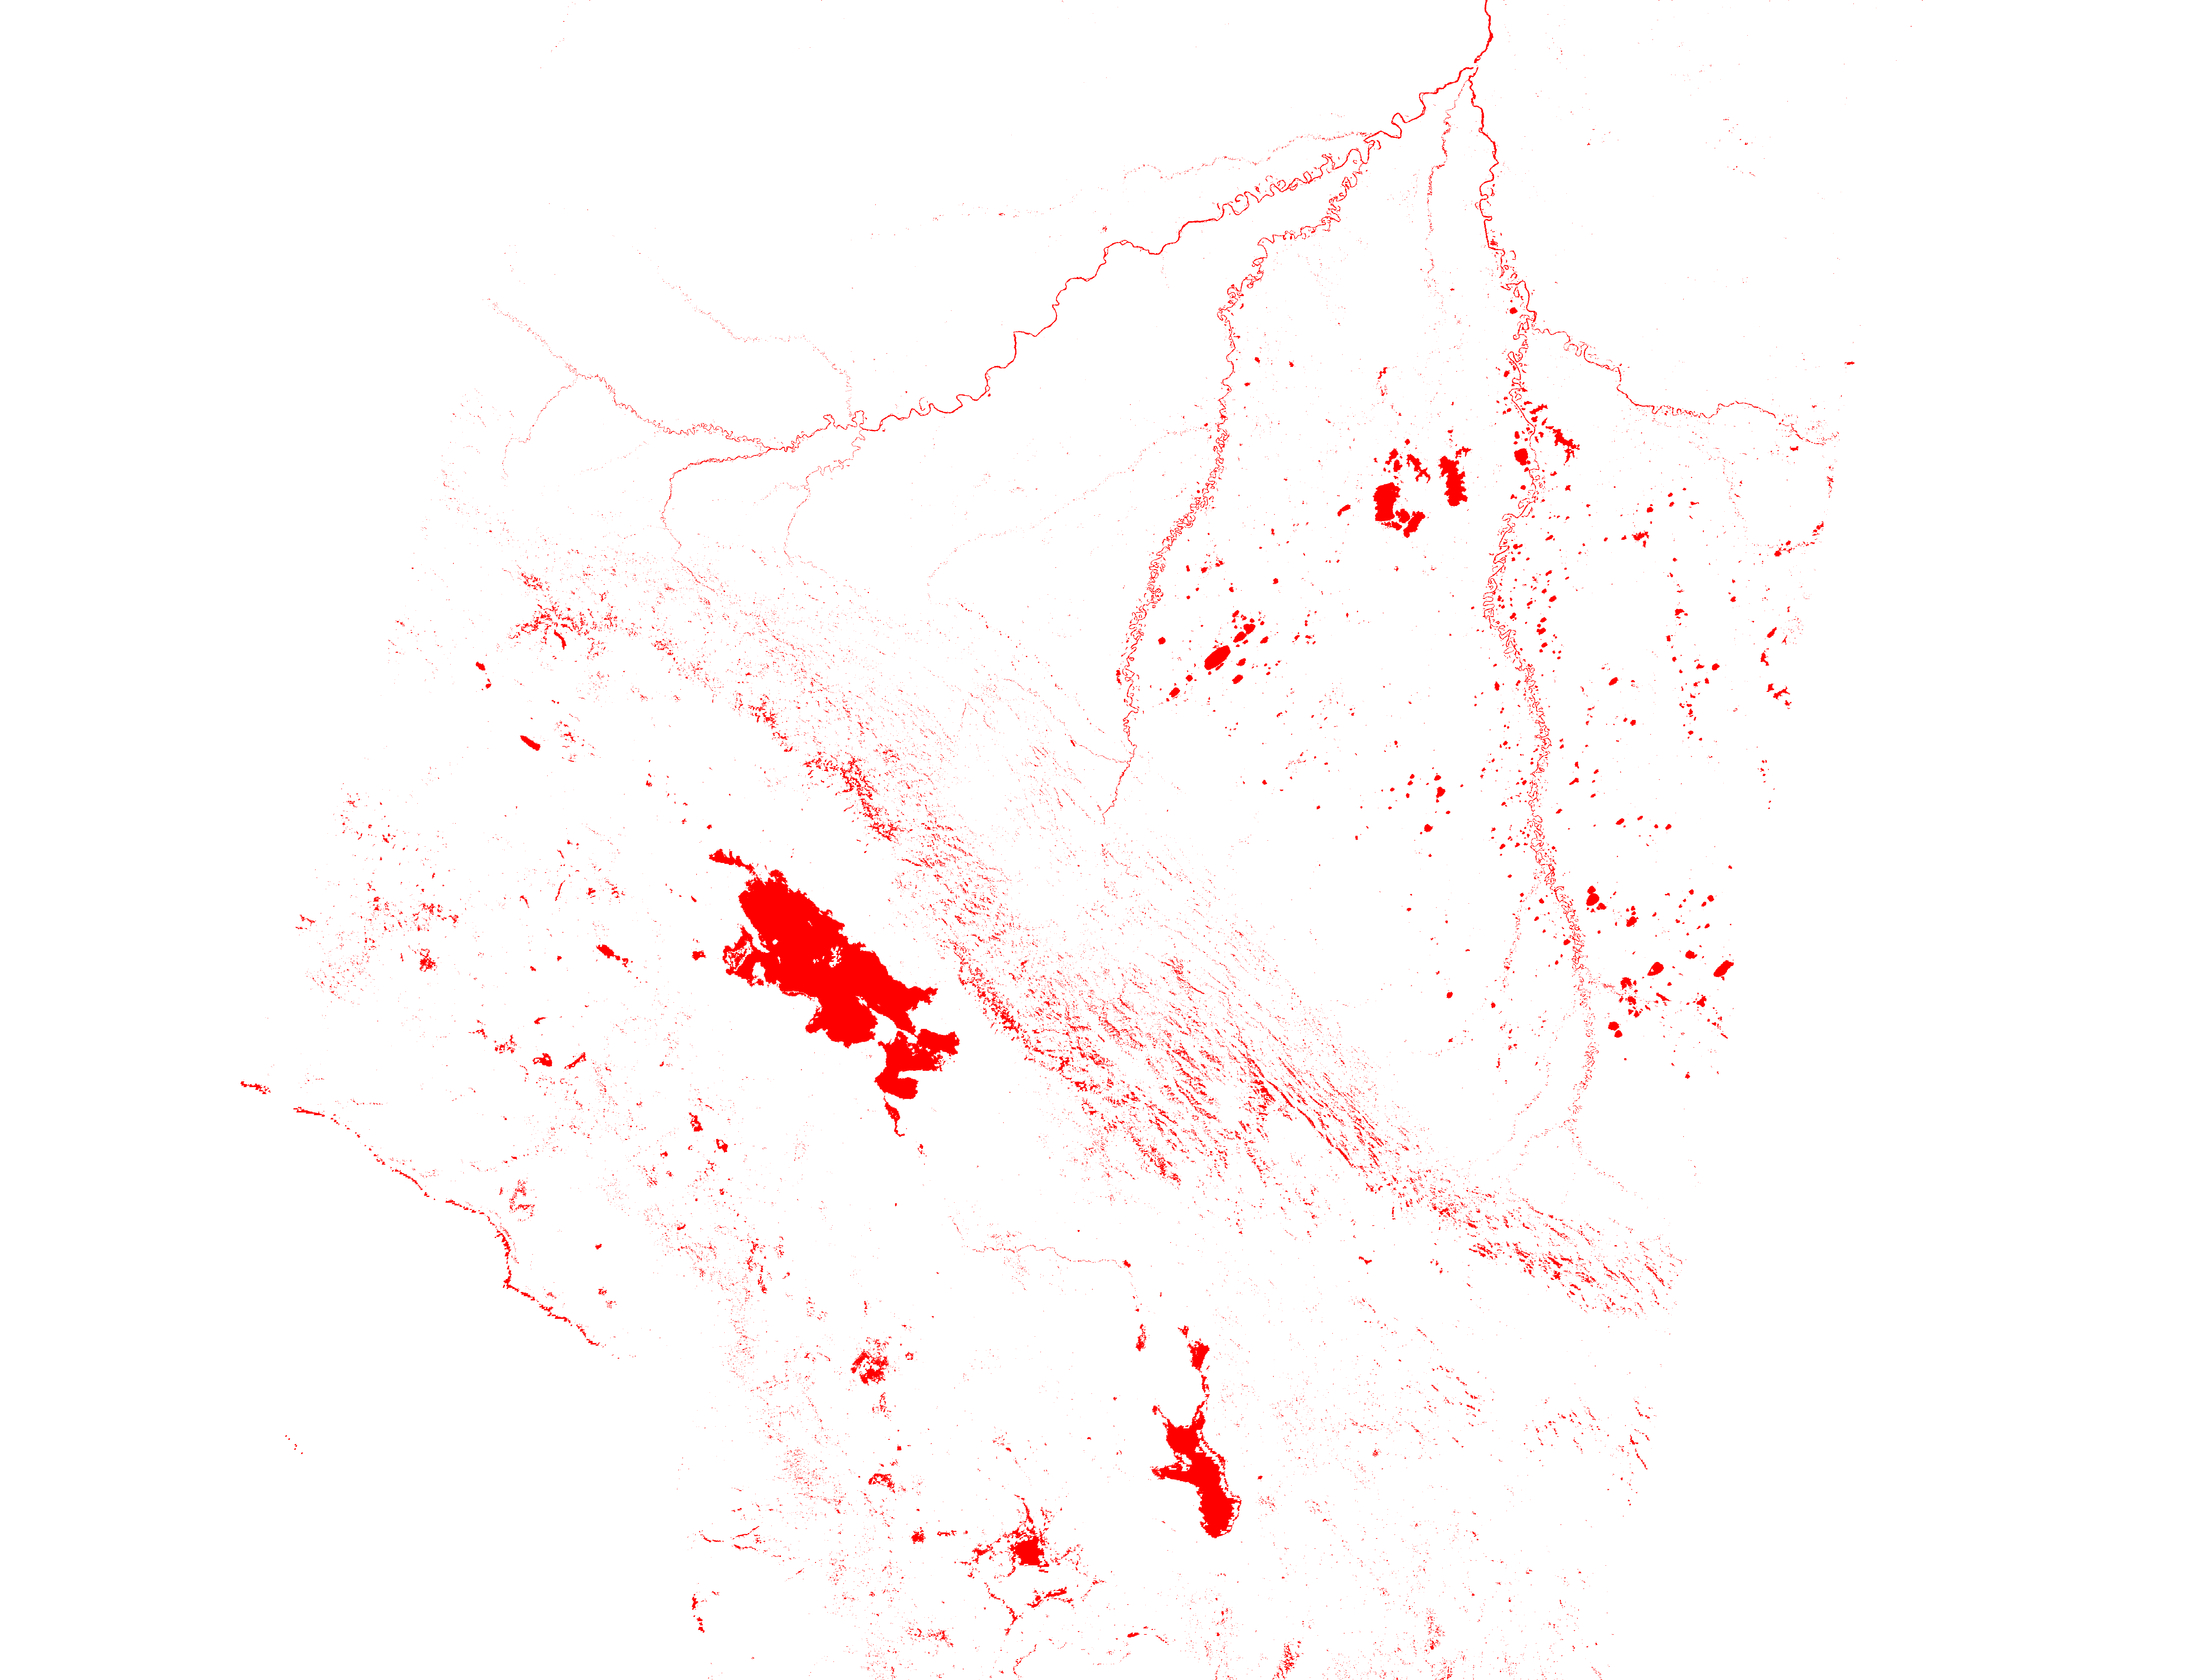
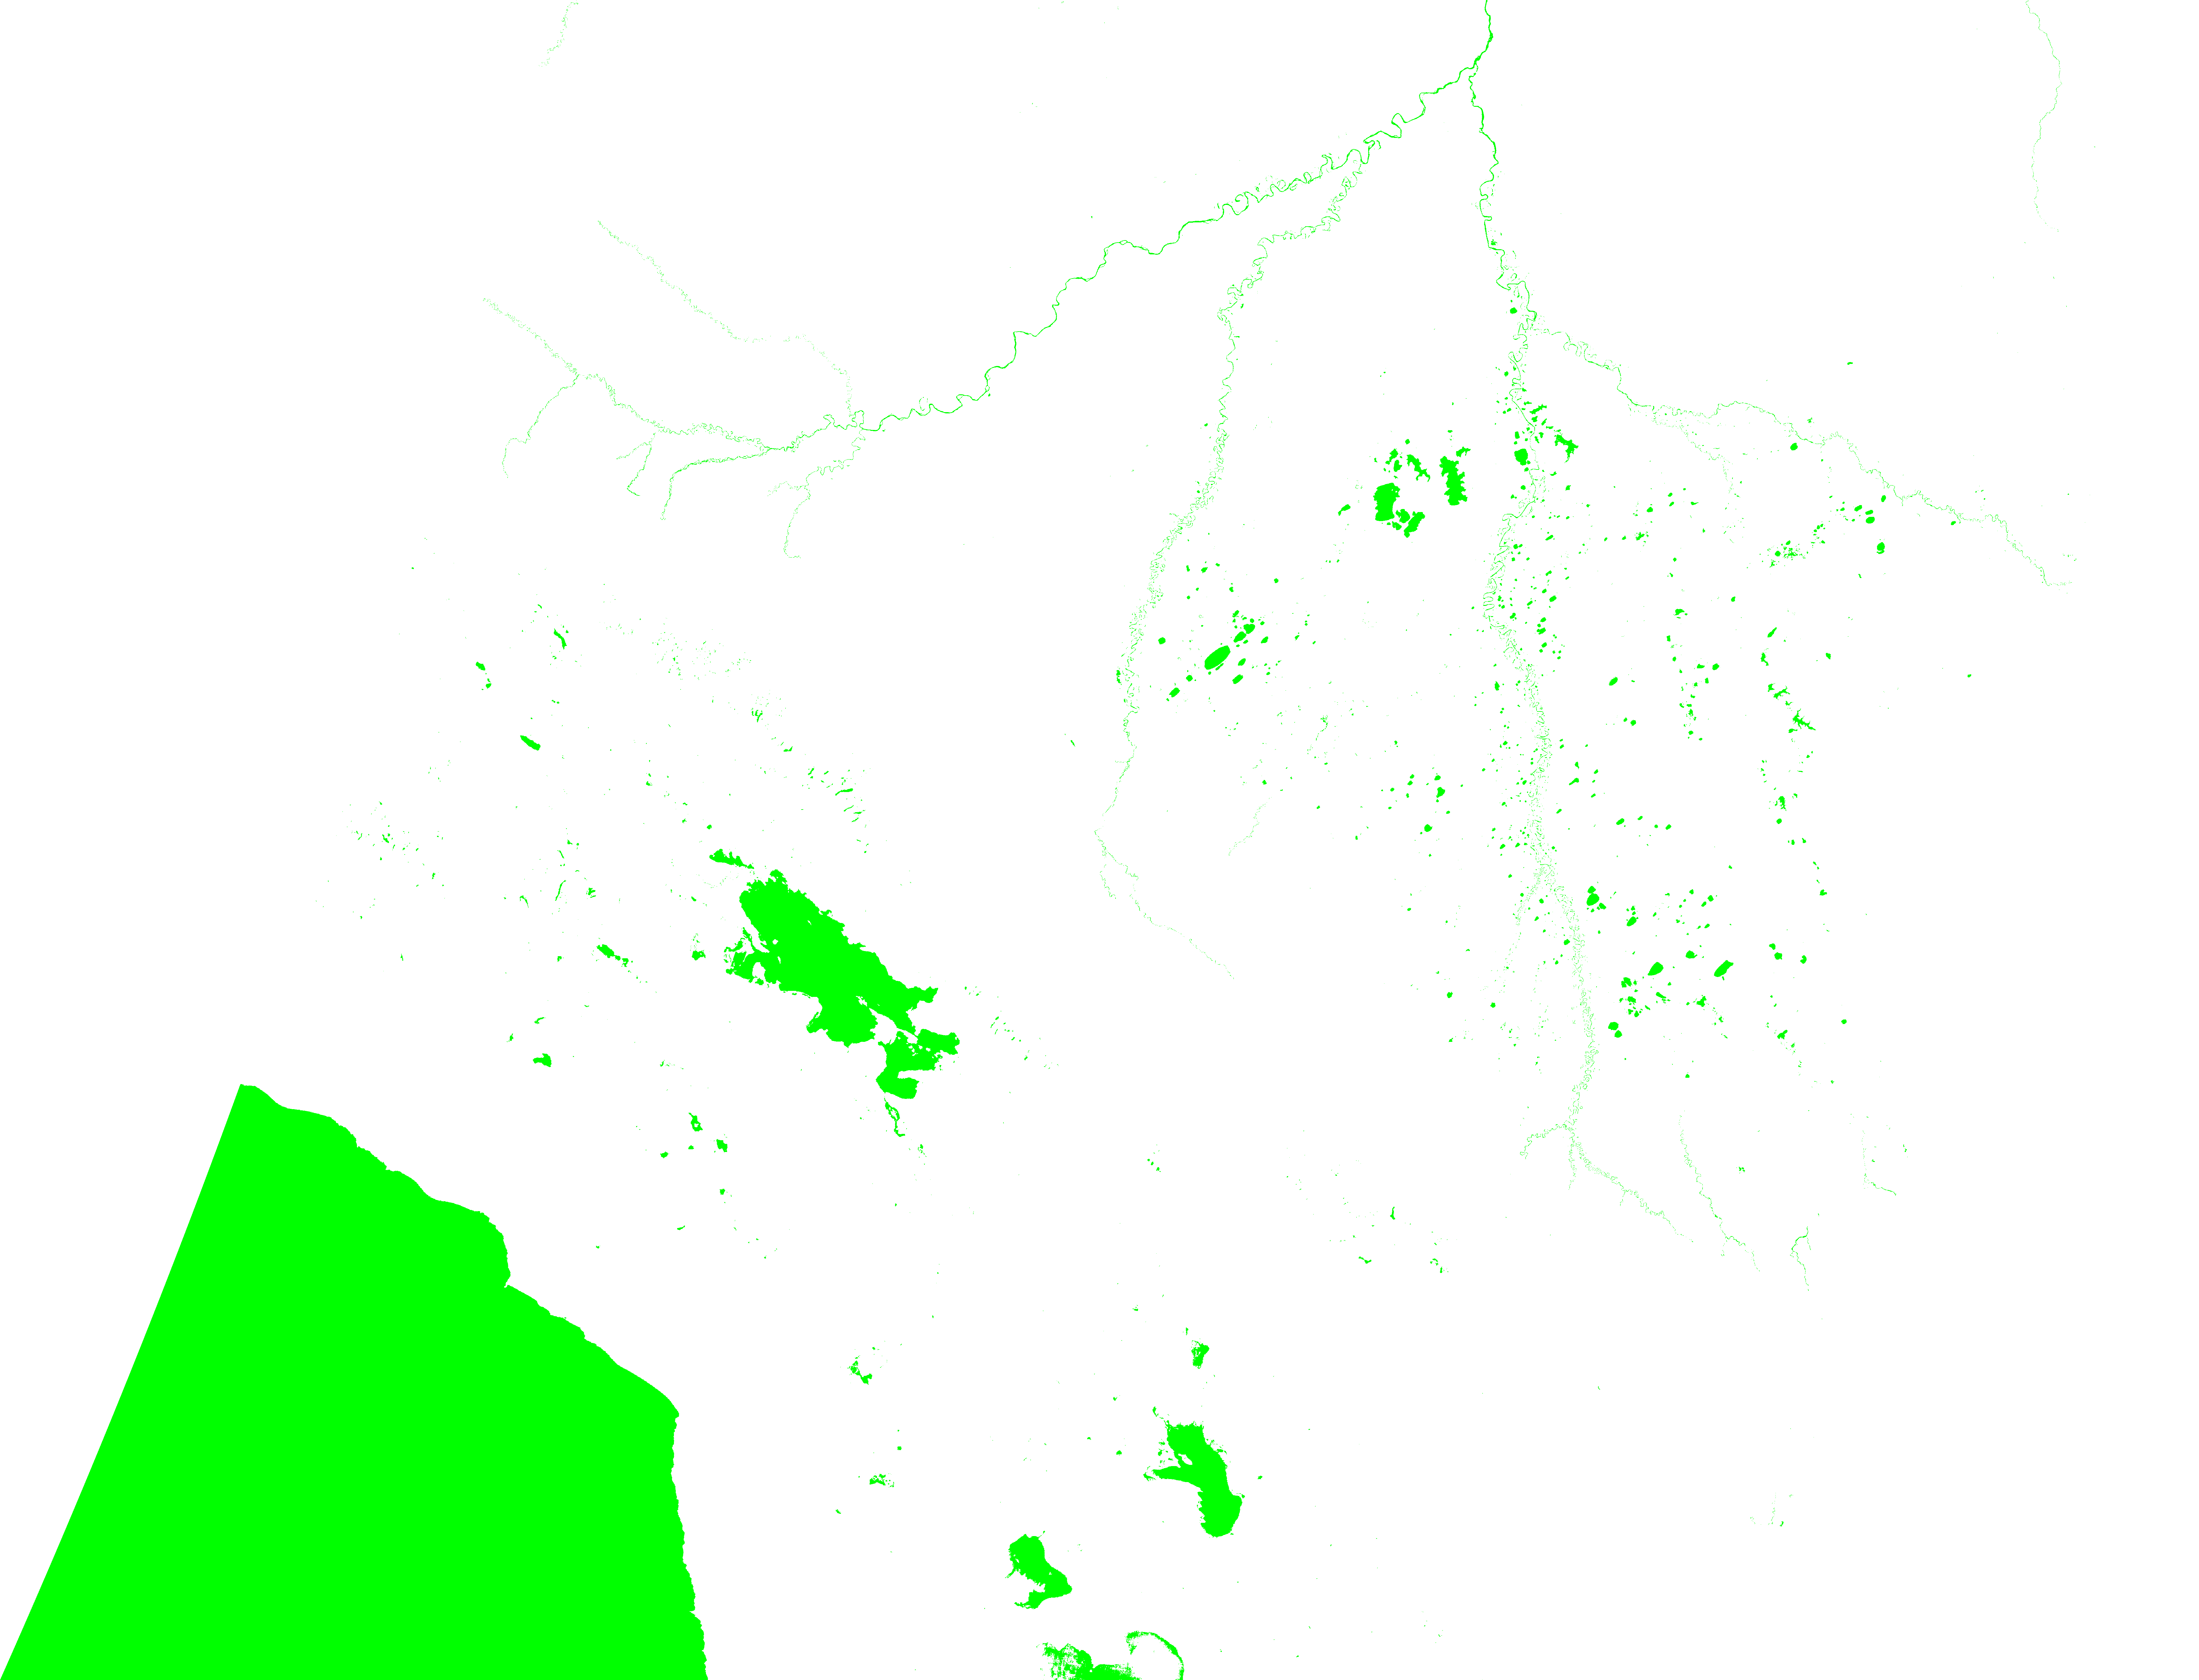
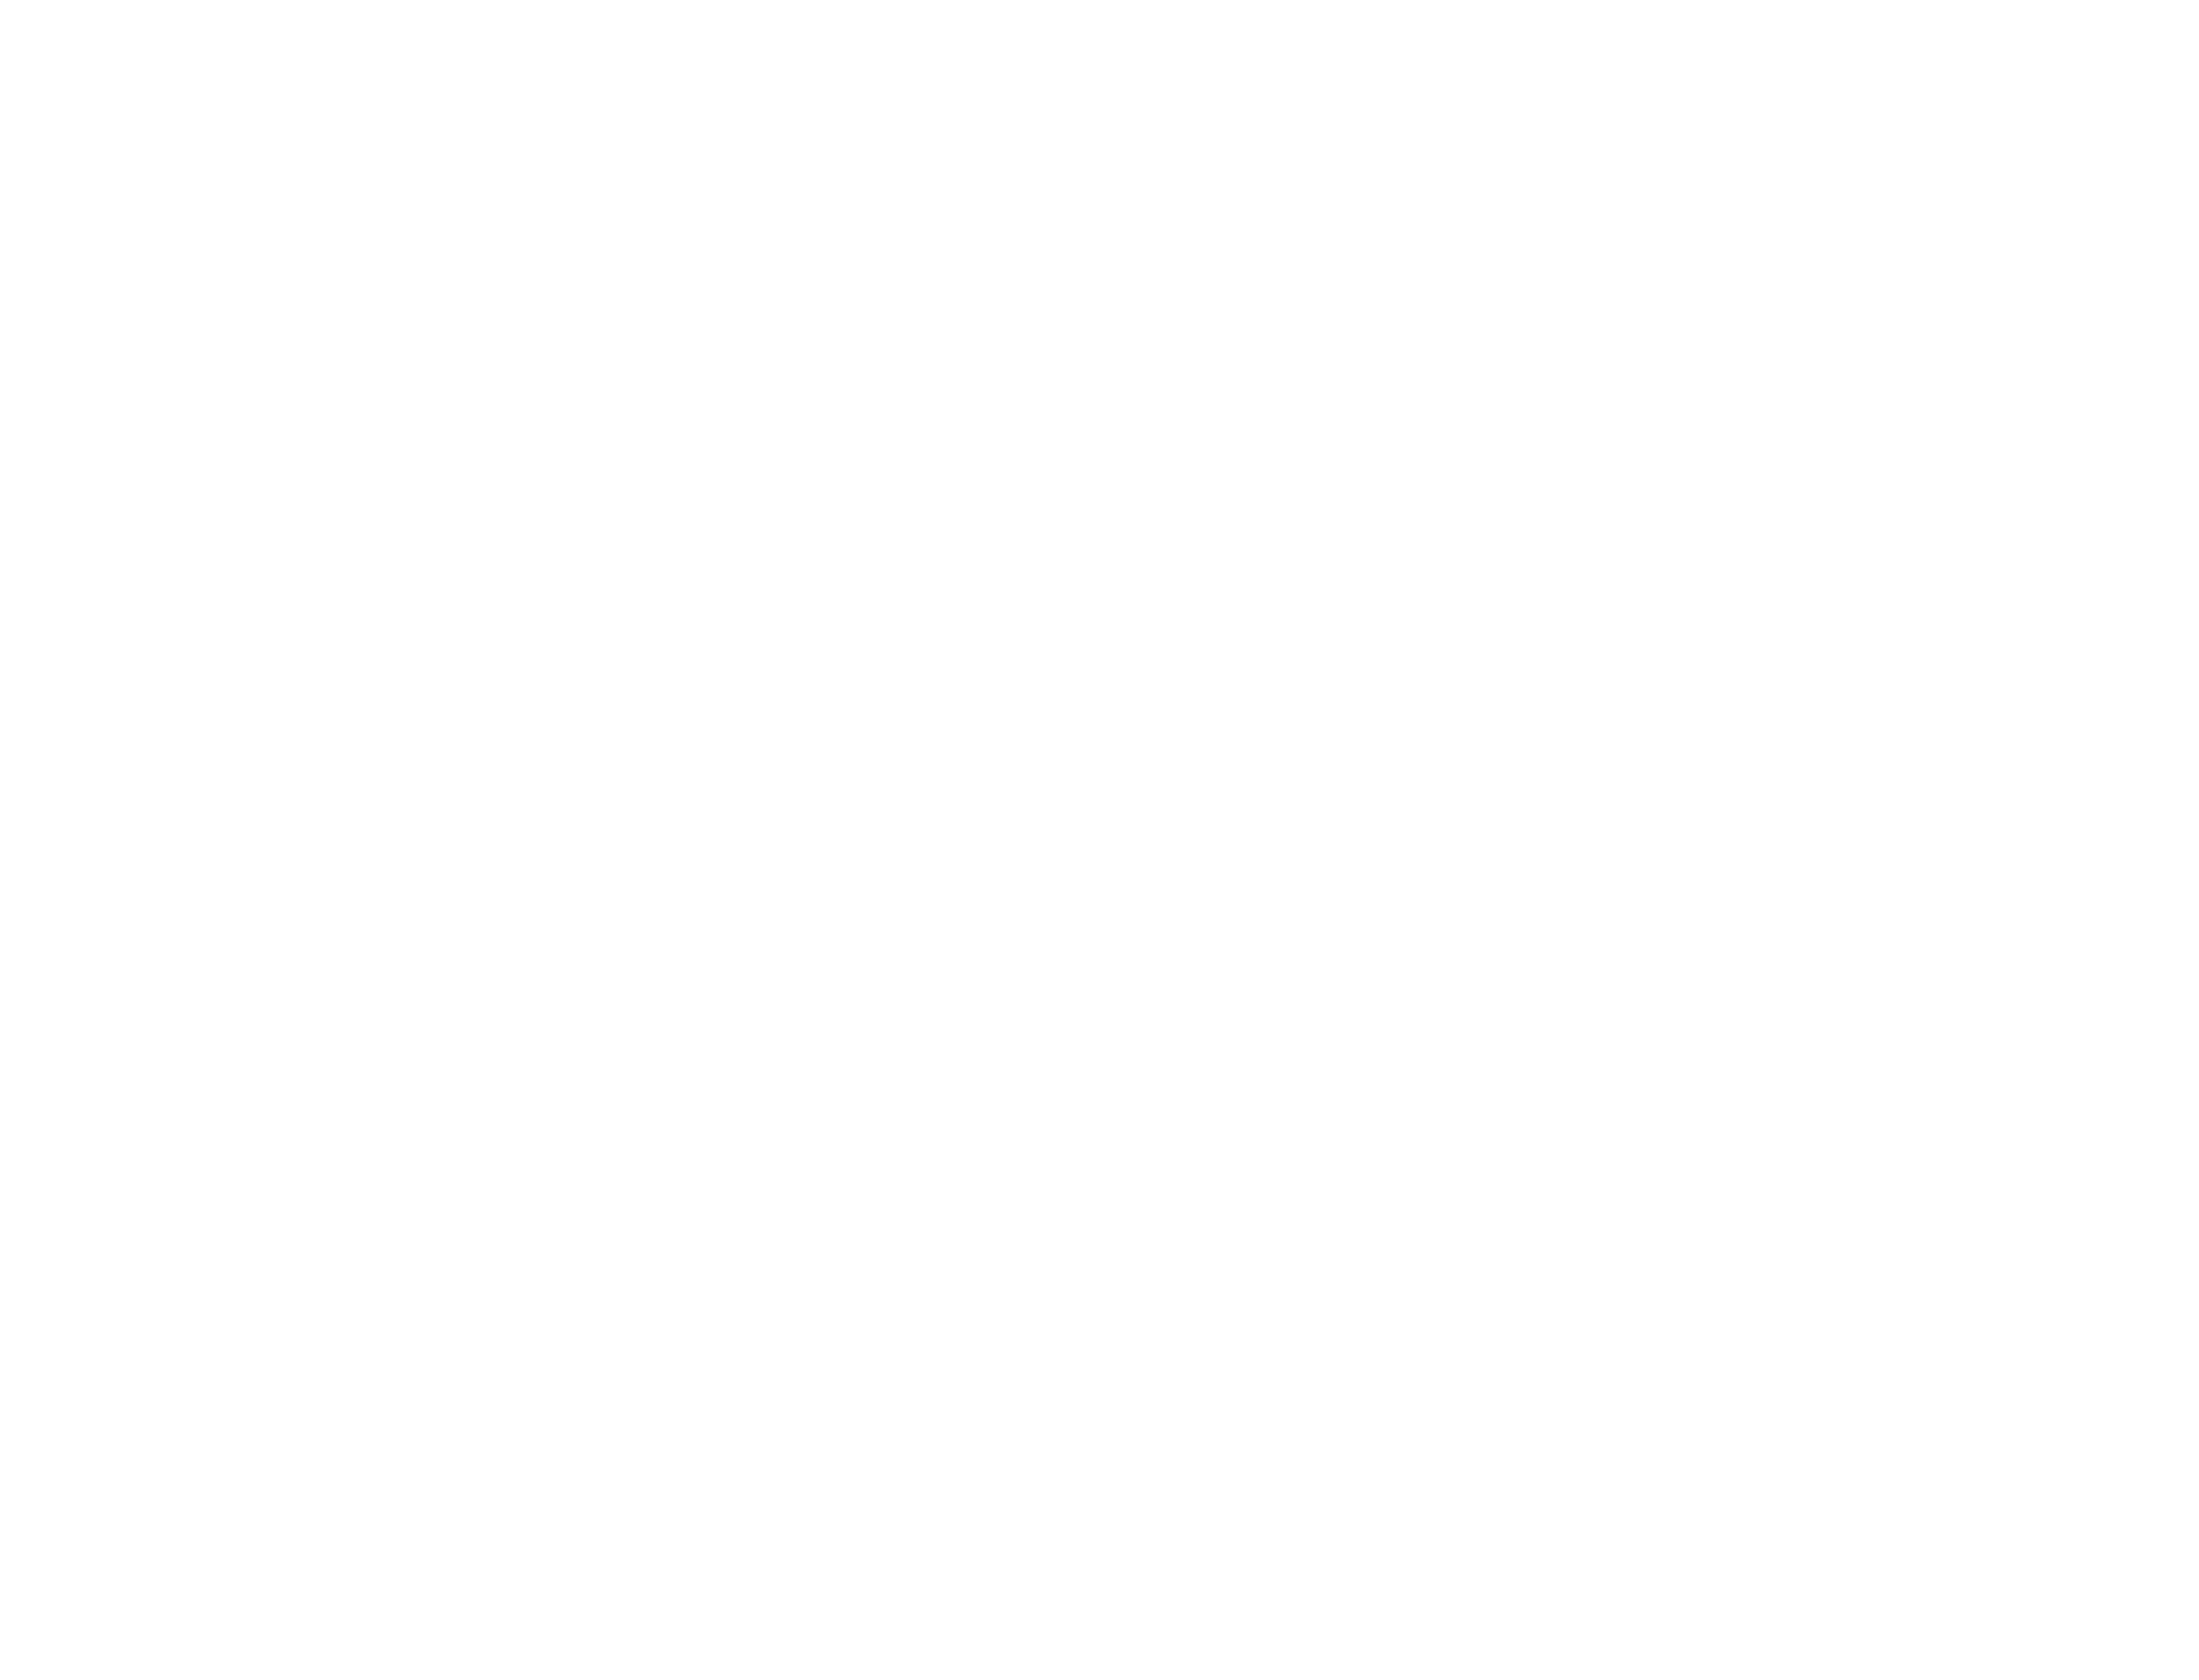

In [57]:
m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())